In [0]:
import tensorflow as tf
import numpy as np

In [0]:
#imports MNIST data from their tutorial
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [0]:
#array containing all the training images
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
mnist.train.num_examples

55000

In [0]:
mnist.test.num_examples

10000

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#converts from 1x724 to 28x28 image
single_image = mnist.train.images[1].reshape(28, 28)

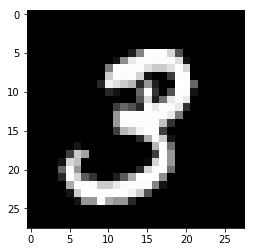

In [0]:
plt.imshow(single_image, cmap='gist_gray')

In [0]:
#PLACEHOLDER(S)
x = tf.placeholder(tf.float32, shape=[None,784])

#PGD VARIABLES
l = tf.Variable(tf.zeros([784, 10]), dtype=tf.float32)                           # left bounds for weight matrix W
r = tf.Variable(tf.random.uniform([784, 10], 1, 2), dtype=tf.float32)            # right bounds for weight matrix W

#ANALYSIS VARIABLES
eps = tf.Variable((r-l)/1000, dtype=tf.float32) # for round-off errors

leps = l - eps #comparison left analysis bounds
reps = r + eps #comparison right analysis bounds

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#OPERATION PLACEHOLDERS
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
add_op = a + b

delta = tf.constant(1.0)

In [0]:
#VARIABLES
current_scope = tf.contrib.framework.get_name_scope()

# HERE'S THE MAGIC:
# placing an element-wise interval (box) constraint using: `constraint=lambda x: tf.clip_by_value(x, l, r)`
# will automatically clip values after each optimization step
with tf.variable_scope(current_scope, reuse=tf.AUTO_REUSE):
  W = tf.get_variable(name="W", initializer=tf.zeros([784, 10]), constraint=lambda x: tf.clip_by_value(x, l, r))
b = tf.Variable(tf.zeros([10]))

In [0]:
#CREATE GRAPH OPERATIONS
y = tf.matmul(x, W) + b

In [0]:
y_true = tf.placeholder(tf.float32, [None, 10])

In [0]:
#LOSS FUNCTION
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y))
#creates a loss function (cross entropy) where labels are true values and logits are predictions

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
#OPTIMIZER
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

train = optimizer.minimize(cross_entropy)

In [0]:
#DEFINE UPDATES TO BOUNDS
leftUpdate = tf.Variable(0.1, dtype=tf.float32)
rightUpdate = tf.Variable(0.1, dtype=tf.float32)

updatel = tf.assign(l, tf.add(l, leftUpdate))
updater = tf.assign(r, tf.add(r, rightUpdate))

In [0]:
#CREATE SESSION
init = tf.global_variables_initializer()

In [0]:
with tf.Session() as sess:
  sess.run(init)
  
  for step in range(1000):
    #first create batch and run step update
    batch_x, batch_y = mnist.train.next_batch(100)
    sess.run(train, feed_dict={x:batch_x, y_true:batch_y})
    #tensorflow has already automatically updated/projected values inside interval
    
    #optional analysis to check that projected within bounds
    lv = sess.run(leps)
    rv = sess.run(reps)
    
    matrix = sess.run(W)
    assert (matrix <= rv).all() #right bounds checking
    assert (matrix >= lv).all() #left bounds checking
    
    #update projection bounds
    sess.run([updatel, updater])
    
  #evaluate the model
  correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_true, 1))
  
  #returns: [True, False, True, True,...] where maximum probability matches true value
  #now convert to --> [1, 0, 1, 1, ...]
  acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #reduce_mean returns percentage of correct
  
  print("Accuracy:", sess.run(acc, feed_dict={x:mnist.test.images, y_true:mnist.test.labels}))
  
  
  
  

Accuracy: 0.1135
